# Neural style transfer

To see the figures in this notebook, you should all the zip files in the same directory. The following are the folders you should watch out and unzip them correctly.
- Folder "**figures**"
- Folder "**content-images**"
- Folder "**style-images**"
- Folder "**generated-images**"
- Folder "**generated-process**"

## Problem statement

In this notebook, we learn [**Neural-Style Transfer**](https://arxiv.org/abs/1508.06576) developed by *Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.* Neural-Style, or Neural-Transfer, allows us to take an image and reproduce it with a new artistic style. The algorithm takes three images:
- a input image that will be optimized to the so-called *generated* image
- a *content* image
- a *style* image
The terminology *generated image* reflects what we learned in the lecture. Of course, this generated image is given as the input in the first place. 


This tutorial will walk you through not only the neural-style algorithm but also some intereating Python implementation technique and a very commonly used VGG-16 convolution neural network.

Below are three examples that are produced by this tutorial. In each example, the images are shown in the order: content image (left) and the style image (right) and the generated image (last image).

<font color="magenta">**Example 1**</font>

<img src="./content-images/dancing.jpg" alt="Content Image" width="300"/>  <img src="./style-images//picasso.jpg" alt="Style Image" width="300"/> <img src="./generated-images/dancing+picasso.png" alt="generated Image" width="300"/> 

<font color="magenta">**Example 2**</font>  

<img src="./content-images/uog-cloister.jpg" alt="Content Image" width="300"/>  <img src="./style-images/happy_new_year.jpg" alt="Style Image" width="300"/> <img src="./generated-images//uog-cloister-happy-new-year.png" alt="generated Image" width="300"/> 

<font color="magenta">**Example 3**</font>  

<img src="./content-images//cat.jpg" alt="Content Image" width="300"/>  <img src="./style-images/mosaic-A.jpg" alt="Style Image" width="300"/> <img src="./generated-images/cat-mosaic.png" alt="generated Image" width="300"/> 

## Further resources

These days it is not difficult to look for online resources. You can easily see a lot of resources online. If you just google "Neural Style transfer implementation", you will probably see a lot of tutorials on this. However, I doubt that they really present the summary of the mathematical background behind the algorithm. Most of the tutorials and provided code is quite complex and assume that you should know the mathematical theory behind Neural Style transform

## What you will read

There are several ways to perform neural style transform. Indeed, in 2016, just one year after the paper [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) was published, another group in Stanford published a slightly different method (of course normally an improved method) for the same goal [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155). 

In this notebook, you will see that I used the same activations in $5$ convolution layers to compute the content loss function and the style loss function. As mentioned in the paper, and probably many other tutorials, only one or two convolution layer (quite deep one) are needed for computing the content loss function and several convolution layers are needed for the style loss function. What I want to demonstrate here is that "You can always play around with what you learned to improve your own understanding rather than just copy/paste different online tutorials."

## Underlying principle

The principle is rather simple: we define two loss functions, one for "measuring" the "*content*" distance between the generated image and the content image, and one for "measuring" the "*style*" distance between the generated image and the style image. As in the lecture, we denote
- $(G)\quad \rightarrow\quad$ generated image
- $(C)\quad \rightarrow\quad$ content image
- $(S)\quad \rightarrow\quad$ style image

Moreover, let $\mathcal{L}_\text{content}(C, G)$ denote the content loss function and $\mathcal{L}_\text{style}(S, G)$ denote the style loss function. Note that although $\mathcal{L}(C, G)$ already carries the meaning of distance between the content image $(C)$ and the generated image $(G)$, the subscript content is still needed in $\mathcal{L}_\text{content}(C, G)$. Similarly, the subscript style in $\mathcal{L}_\text{style}(S, G)$ is also needed. This is because the way the distance between $(C)$ and $(G)$ is computed is different from the way the distance between $(S)$ and $(G)$ is computed. Then, the generated image is obtained by minimizing the loss function
$$
\mathcal{L}(G) = \alpha \mathcal{L}(C, G) + \beta \mathcal{L}(S, G)\quad\longrightarrow \min
$$
where $\alpha$ and $\beta$ are the weights for the content loss function and the style loss function, respectively.

We will focus on two important tasks:
- Computing the content loss function
- Computing the style loss function
Futher explanation will be given on the way.

In [1]:
# First thing first
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

## Theory and mathematical background for Neural Style Transfer

As in many applications in computer visions, there are various ways to implement the neural style transfer. One of the key component is the convolution neural network to be used. Herein we will use VGG-19 convolution neural network (see figure). We will discuss this model shortly.

<img src="./figures/vgg19.png" alt="Content Image" width="1200px"/>

Then, we need to compute
- Content loss function 
- Style loss function
You will see that we shall use only a few layers in the VGG-19 network for computing the *content* loss function and even *fewer* convolution layers for computing the *style* loss function

### About VGG-19 convolution neural network

In [2]:
vgg19 = models.vgg19(weights='DEFAULT')
f = open("vgg19-architecture.txt", "w")     # open the txt file

# Write the full architecture on the txt file
banner = 90*"=" + "\n"
f.write(banner + f"{'FULL VGG19 ARCHITECTURE':^90}" + "\n" + banner)
f.write(str(vgg19) + "\n\n") # write the architecture into the txt file
# Write the member vgg19.features on the same txt file
f.write(banner + f"{'Member "features" in VGG19: vgg19.features':^90}" + "\n" + banner)
f.write(str(vgg19.features) + "\n\n")
# Write the member vgg19.avgpool on the same txt file
f.write(banner + f"{'Member "avgpool" in VGG19: vgg19.avgpool':^90}" + "\n" + banner)
f.write(str(vgg19.avgpool) + "\n\n")
# Write the member vgg19.classifier on the same txt file
f.write(banner + f"{'Member "avgpool" in VGG19: vgg19.classifier':^90}" + "\n" + banner)
f.write(str(vgg19.classifier))
f.close()           # close the file

# After executing this code cell, you can go to the file "vgg19-architecture.txt" 
# in the same folder this Jupyter Notebook sits in to see the VGG19 architecture.


According to the above figure and also the architecture string, we can see that the model consists of three key members:
- The member "vgg19.features" is a Sequential module that, by itself, consists of $37$ submodules. These submodules are either convolution layer, ReLU activation, or max-pooling layer.
- The member "vgg19.avgpool" is an adaptive average pooling layer. See [AdaptiveAvgPool2D](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html) for PyTorch documentation. To understand what this layer does, read this fantastic explanation [Adaptive Average Pooling Layer](https://medium.com/@akp83540/adaptive-average-pooling-layer-cb438d029022)
- The member "vgg19.classifer" is a Sequential module that, by itself, consists of $7$ submodules. These submodules are the familiar modules: Linear layer, ReLU activation, Dropout layer

**Further explanation on the architecture of the VGG19**  
As we can see, the submodule $(36)$ of the member vgg19.features has the output with $512$ channels, or $512$ feature maps. We don't know the height and the width of the image output from this layer, but we know that it has $512$ channels. What the member vgg19.avgpool does is to apply several filters (in this case $512$ filters) with appropriate size so that the output will have the size $(7, 7, 512)$. This is where the word "adaptive" comes from. The filter size is determined so that the output $(H, W) = (7, 7)$ and the number of channels kept unchanged, therefore the output size $(7, 7, 512)$. Now, this output is flattend to a vector of size $7 \cdot 7 \cdot 512 = 25088$. This is why you see the first submodule $(0)$ in vgg19.classifer is the linear layer with the input feature size $25088$, which is perfectly equal to the number of activations after vgg19.avgpool.



In [3]:
# Number of activations after vgg19.avgpool
print(7 * 7 * 512)

25088


**Remark on the model architecture presented in PyTorch vs TensorFlow**

If you use TensorFlow to import the classic convolution neural network, you will probably notice that the way we access to submodules, including various layers such as Linear layer, convolution layers, pooling layers and activation layers, of the model is different. Well, this is not a big surprising as two machine learning frameworks are developed by two groups of developers and two different set of design principles.

### Compute content loss function

**Make generated image $(G)$ match the content image $(C)$**

One goal you should aim for when performing neural-style transform is for the content in generated image $(G)$ to match the content of image $(C)$. To do so, you'll need an understanding of <b> shallow versus deep layers </b>:

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>. 

<font color='magenta'>**To choose a "middle" activation layer $\mathbf{a}^{[l]}$**</font>  
You need the "generated" image $(G)$ to have similar content as the input image $(C)$. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you will usually get the most visually pleasing results if you choose a layer from somewhere in the middle of the network--neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.
* After you have finished this tutorial, feel free to come back and experiment with using different layers to see how the results vary!

<font color='magenta'>**To forward propagate content image $(C)$**</font>  
* Set the image $(C)$ as the input to the pretrained VGG19 network, and run forward propagation.  
* Let $\mathbf{a}^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, this was written as $\mathbf{a}^{[l](C)}$, but here the superscript $[l]$ is dropped to simplify the notation.) This will be an $(n_{C}, n_{H}, n_{W})$ tensor in PyTorch.

<font color='magenta'>**To forward propagate generated image $(G)$**</font>  
* Repeat this process with the image $(G)$: Set $(G)$ as the input, and run forward propagation. 
* Let $\mathbf{a}^{(G)}$ be the corresponding hidden layer activation. 

<font color='magenta'>**Content loss function**</font>  
One goal we aim for when performing neural-style transfer is for the content in the generated image $(G)$ to match the content of the image $(C)$. A method to achieve this is to compute the content loss function, which will be defined as
$$\mathcal{L}_\text{content}(C,G) =  \frac{1}{ n_H \cdot n_W \cdot n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the loss. 
* For clarity, note that $\mathbf{a}^{(C)}$ and $\mathbf{a}^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations.

As you can see, the content loss function can be easily computed by using Mean Squared Error loss.

In this running example, the content image $(C)$ will be the Cloister of the University of Glasgow. Run the code below to see the picture.

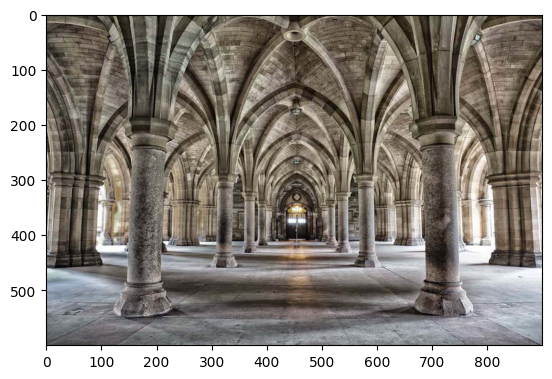

In [4]:
content_image = Image.open("./content-images/uog-cloister.jpg")
plt.imshow(content_image)
plt.show()

### Compute style loss function

<font color='magenta'>**Style matrix**</font>  

- The style matrix is also called a "Gram matrix".
- In linear algebra, the Gram matrix $\mathbf{G}$ of a set of vectors $(\mathbf{v}_{1}, \ldots, \mathbf{v}_{n})$ is the matrix of dot products of these vectors, whose entries are defined as
$$
G_{ij} = \mathbf{v}_{i}^{T} \cdot \mathbf{v}_{j}
$$
Note that this matrix is denoted by $\mathbf{G}$ and do not confuse this notation with the generated image $(G)$.
- In other words, the value $G_{ij}$ compares how similar vector $\mathbf{v}_{i}$ is to vector $\mathbf{v}_{j}$. If they are highly similar, you would expect them to have a large dot product, and thus the value $G_{ij}$ to be large.
- As there is a slight collision in the denotation between the Gram matrix $\mathbf{G}$ and the generated image $(G)$, we shall use $\mathbf{G}_\text{gram}$ to make it easy to distinguish the difference between the generated image $(G)$ and the Gram matrix $\mathbf{G}^\text{gram}$.

<font color='magenta'>**Compute Gram matrix**</font>  

We will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose
$$
\mathbf{G}^\text{gram} = \mathbf{A}_\text{unrolled}\,\mathbf{A}_\text{unrolled}^{T} \tag{1}
$$
where the unrolled matrix $\mathbf{A}_\text{unrolled}$ has the size $(n_{C}, n_{H} \cdot n_{W})$. That is, the activations $\mathbf{a}^{[l]}$ of size $(n_{C}, n_{H}, n_{W})$ is in the the second and the third dimension for the height and the width of the activations $\mathbf{a}^{[l]}$ (see figure below)

<img src="./figures/NST_LOSS.png" style="width:800px">

Equation (1) can be visualized in the following figure

<img src="./figures/gram.png" style="width:1000px">

<font color='magenta'>**Gram matrix: Correlation**</font>  

Computing the Gram matrix $\mathbf{G}^\text{gram}$ results in a matrix of dimension $(n_{C}, n_{C})$, where $n_{C}$ is the number of filters (channels). The value $G_{ij}^\text{gram}$ measures how similar the activations of filter (channel) $i$ are to the activations of filter (channel) $j$.

<font color='magenta'>**Gram matrix: Prevalence of patterns of textures**</font>  
- The diagonal elements $G_{ij}^\text{gram}$ measure how *active* a filter $i$ is.
- For example, suppose the filter $i$ is detecting vertical textures in the image. Then, $G_{ii}^\text{gram}$ measures how common vertical textures are in the image as a whole.
- If $G_{ii}^\text{gram}$ is large, this means that the image has a lot of vertical texture.
By capturing the prevalence of different styles of features (reflected by $G_{ii}^\text{gram}$), as well as how much different features occur together (reflected by $G_{ij}^\text{gram}), the style matrix $\mathbf{G}^\text{gram}$ measures the style of a matrix.

<font color='magenta'>**Style loss function**</font>  

Using the Gram matrix, our next goal is to define the style loss function which measure the distance between Gram matrix of the style image $(S)$ and the Gram matrix of the generated image $(G)$.
- For now, you will use only a single hidden layer $\mathbf{a}^{[l]}$
- The corresponding style loss for this layer $[l]$ is defined as
$$
\mathcal{L}_\text{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S),\text{gram}}_{i,j} - G^{(G),\text{gram}}_{i,j})^2\tag{2}
$$
- In this equation, $\mathbf{G}{(S),\text{gram}}$ is the Gram matrix for the style image $(S)$, and $\mathbf{G}^{(G),\text{gram}}$ is the Gram matrix for the generated image $(G)$.
- Make sure you remember that this loss function is computed using the hidden layer activations for a particular hidden layer in the network $\mathbf{a}^{[l]}$.

<font color='magenta'>**Style weights**</font>  

- So far you have captured the style from only one layer
- You will get better result if you "merge" style losses from several different layers
- Each layer will be given weights $\lambda^{[l]}$ that reflect how much each layer will contribute to the style
- By default, give each layer equal weight, and the weights add up to $1$, that is $\sum\limits \lambda^{[l]} = 1$. Note that $l$ is taken from the layers used for computing the style loss function. The layer $l$ does not necessarily mean every layer in the VGG-19

## Implementation


<font color='magenta'>**Regarding computation of loss function**</font>  
Althought the theory is rather complicated, the implementation of neural style transfer using PyTorch turns out quite simple. It is so simple that computing the content loss function $\mathcal{L}_\text{content}(C, G)$ for one single layer needs only one line of code using mean squared error loss. To compute content loss function using many chosen layers in the VGG-19, we only need to sum the content loss function for those chosen layers. Similarly, it is also rather simple to compute style loss function $\mathcal{L}_\text{style}(S, G)$ because we need only two lines of code to compute the Gram matrix and another line for compute the style loss using mean squared error loss. Indeed, the code for computing the content and style loss functions is so simple that it is probably unncessary to write Python functions to compute these loss functions separately. We can compute them in the training loop.

<font color='magenta'>**Compute activations by passing images through model**</font>  
This step actually involves more technical implementation for two reasons.
- We need to choose the layers for computing the activations used for the content loss $\mathcal{L}_\text{content}(C, G)$. We can choose several layers rather than just one layer although one layer is quite enough if the layer is not too shallow (only for simple features).
- Similarly, we need to choose the layers for computing the activations used for the style loss $\mathcal{L}_\text{style}(S, G)$. The chosen layers for the style loss are not necessarily the same as those for the content loss although such a choice is not impossible.
- For the above reason, we want to forward the input image, either content image, style image or generated image through the VGG-19 network differently, and take out the output differently.

### Define the model

For simplicity, this tutorial will use the same chosen layers for both content loss function and style loss function. We don't need members vgg19.avgpool and vgg19.classifer in our model as only want to use the convolution layers in the VGG-19 network. As for the activations, we choose the first convolution layer in vgg19.features and the every other convolution layers right after max pooling layers. Below, I just copy the modules in vgg19.features. As we can see, the convolution layers right after the max pooling layers correspond to the submodules (5), (10), (19), (28) and the first convolution layer corresponds to the submodule (0). The way to access such modules is to use indexing just like indexing into a list.

```python
(features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (24): ReLU(inplace=True)
    (25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (26): ReLU(inplace=True)
    (27): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (31): ReLU(inplace=True)
    (32): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (33): ReLU(inplace=True)
    (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (35): ReLU(inplace=True)
    (36): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
```

In [5]:
# This code cell illustrate how to get the convolution layers
# described in the above markdown.
vgg19 = models.vgg19(weights='DEFAULT')
vgg19_features = vgg19.features
chosen_module = [0, 5, 10, 19, 28]
for i, m in enumerate(chosen_module):
    print(f"Convolution {i+1}: {vgg19_features[m]}")

Convolution 1: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Convolution 2: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Convolution 3: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Convolution 4: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Convolution 5: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [6]:
class NeuralStyle(nn.Module):
    def __init__(self):
        super(NeuralStyle, self).__init__()

        self.chosen_layers = [0, 5, 10, 19, 28]
        self.model = models.vgg19(weights='DEFAULT').features[:29]     # We don't need after 28...

    def forward(self, x):
        activations = []

        for layer_num, layer in enumerate(self.model):
            x = layer(x)    # Forward as normal
            
            # We only take out the activations if the activations 
            # are outputs of the chosen layers.
            if layer_num in self.chosen_layers:
                activations.append(x)
            
        return activations

### Read and process input images: content image, style image

Since the content image and style image we use may have different size, we need to resize them so that they have the same size. Of course, we can also crop the images so that they have the same size. Normally, we want to resize both the content and style images because we don't want to lose the any parts of these images. Then, the images needed to be converted to tensors for later computation.

Since the generated image is the outcome of the training process, the size of the image is actually the number of parameters to be sought. For example, if the generated image has the size $(256, 256)$ the number of parameters to be minimized is $256 \cdot 256 = 65536$. Of course, according to different computer's resources, we have to be realistic with the size of the generated image. If we want to generate an image of size $(1024, 1024)$, we need to solve a minimization problem with $1024 \cdot 1024 = 1048576$ (more than 1 million) variables. This is probably not feasible on many small laptops.

For merging the image Uni of Glasgow cloister and the image of happy new year, I use the image size $(400, 600)$. Please feel free to play around with the image size to see the effect of speed.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
imsize = (400, 600)
transform = transforms.Compose([
    transforms.Resize(size=imsize),
    transforms.ToTensor()
])

def load_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image.to(device)

If you want to play around with different figures, this is where you can define the content image, style image.

In [8]:
content_name = 'uog-cloister'
content_ext = '.jpg'
content_path = './content-images/' + content_name + content_ext
style_name = 'happy_new_year'
style_ext = '.jpg'
style_path = './style-images/' + style_name + style_ext

content_img = load_image(image_path=content_path)
style_img = load_image(image_path=style_path)

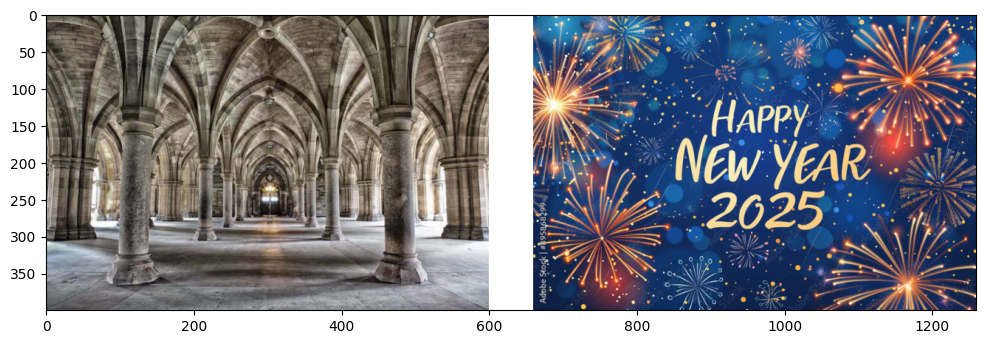

In [9]:
# Show the images
content_img_np = content_img.squeeze().permute((1, 2, 0)).to('cpu').detach().numpy()
style_img_np = style_img.squeeze().permute((1, 2, 0)).to('cpu').detach().numpy()

plt.figure(figsize=(12, 5.8))
plt.imshow(np.concatenate((content_img_np, 
                           np.ones(shape=(imsize[0], int(0.1*imsize[1]), 3)), 
                           style_img_np), axis=1))
plt.show()

The generated image $(G)$ is the parameters to be minimized. Therefore, we need grad for this tensor.

In [10]:
generated_img = content_img.clone().requires_grad_(True)

### Choosing optimizer

<font color='magenta'>**General discussion on a few optimization methods**</font>  

To minimize the loss function $\mathcal{L}(G)$, in theory we can choose any optimization methods. In many machine learning applications, the [Stochastic Gradient Descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizers `optim.SG()` and the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer `optim.Adam()` are normally deployed. The stochastic gradient descent method is the first-order gradient method because only the gradient of the loss function is needed in the computational process. The Adam method is supposed to have a better convergence rate as compared to the SGD because it tries to approximate the second-order derivatives of the loss function through the first moment and the second moment. In terms of convergence rate, we can classify both Stochastic Gradient Descent and Adam methods as first-order gradient descent method. Although by using momentum vector, first moment and second moment vectors can improve the convergence rate, we can improve the convergence rate of the above-mentioned methods, they do not really compute the second derivative of the function to be minimized. If you are interested in why these methods are still widely used while we know that there are many other better methods to use, then the paper [The Tradeoffs of Large Scale Learning](https://proceedings.neurips.cc/paper_files/paper/2007/file/0d3180d672e08b4c5312dcdafdf6ef36-Paper.pdf) discusses this topic in detail 


<font color='magenta'>**About LBFGS optimization method**</font>  

In this notebook, we shall use the [LBFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) optimization method. This is a quote from Wikipedia for this method
> Limited-memory BFGS (L-BFGS or LM-BFGS) is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory. It is a popular algorithm for parameter estimation in machine learning. The algorithm's target problem is to minimize $f(\mathbf {x} )$ over unconstrained values of the real-vector $\mathbf {x}$ where $f = f(\mathbf{x})$ is a differentiable scalar function.

As you can see, the keyword here is "quasi-Newton" method. Optimization methods in the family of Newton methods have the second-order convergence rate and use the second-order derivative of the function $f(\mathbf{x})$. The LBFGS method tries to approximate the second-order derivative and achieves almost second-order convergence rate.

The authors of the paper pointed out that LBFGS should be used on a Quora or Reddit discussion. I read the recommendation of the authors of this paper some time ago but I cannot find out the link anymore. However, this blog post [Picking an optimizer for Style Transfer](https://blog.slavv.com/picking-an-optimizer-for-style-transfer-86e7b8cba84b) makes a really great job explaining why LBFGS is recommended in the Neural Style transfer. My short summary is that the LBFGS method gives the best convergence rate among all the optimization methods provided in PyTorch library.

<font color='magenta'>**About LBFGS documentation**</font>   

But if you look at the [LBFGS documentation in PyTorch](https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html) you probably don't find it very useful as there is no meaning example on how to use it.

### Example of using LBFGS optimizer 

Below, I try to give an example on how to use it. To illustrate how the LBFGS is better than other methods, we need a dataset that leads to slow convergence if the stochastic gradient descent and the Adam methods are used. Then, we shall use the LBFGS to obtain the better convergence rate. To this end, we shall try to minimize the 2-dimensional Rosenbrock function
$$
f(x_1, x_2) = (1 - x_{1})^2 + 100 (x_2 - x_{1}^2)^2
$$
The minimum point is obtained by solving the equation $\nabla f(\mathbf{x}) = \mathbf{0}$. In fact, it is very easy to see the optimal solution with solving the equation $\nabla f(\mathbf{x}) = \mathbf{0}$. The solution is $(x_1, x_2) = (1, 1)$ where $f(\mathbf{x}) = 0$ because $f(\mathbf{x}) \geq 0$.

This is a challenging function to minimize by using a gradient descent method or Adam method.

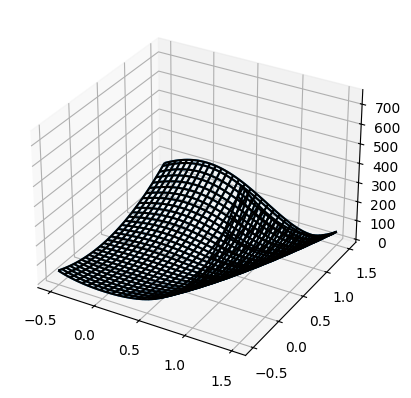

In [11]:
x1 = np.linspace(-0.5, 1.5, 60)
x2 = np.linspace(-0.5, 1.5, 60)
X, Y = np.meshgrid(x1, x2, indexing='ij')
Z = (1 - X)**2 + 100 * (Y - X**2)**2

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Default behavior is axlim_clip=False
ax.plot_wireframe(X, Y, Z, color='C0')

# When axlim_clip=True, note that when a line segment has one vertex outside
# the view limits, the entire line is hidden. The same is true for 3D patches
# if one of their vertices is outside the limits (not shown).
ax.plot_wireframe(X, Y, Z, color='k', axlim_clip=True)
plt.show()

In [12]:
# 2d Rosenbrock function
def f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

In [13]:
# Gradient descent
x_optimal = 5*torch.ones(2)
x_optimal.requires_grad = True
# You need learning rate lr = 5e-5 for convergence.
# If you don't believe me, try to modify the learning rate
# and observe the result by yourself.
SGD_optimizer = optim.SGD([x_optimal], lr=1e-6) 
history_gd = []
n_iterations = 100
for i in range(n_iterations):
    SGD_optimizer.zero_grad()
    objective_func = f(x_optimal)
    objective_func.backward()
    SGD_optimizer.step()
    history_gd.append(objective_func.item())

print(f"solution after 100 iterations:\n {x_optimal}")

solution after 100 iterations:
 tensor([3.2887, 5.2089], requires_grad=True)


In [14]:
# Gradient descent
# Gradient descent
x_optimal = 5*torch.ones(2)
x_optimal.requires_grad = True

# You need learning rate lr = 5e-5 for convergence.
# If you don't believe me, try to modify the learning rate
# and observe the result by yourself.
Adam_optimizer = optim.Adam([x_optimal], lr=5e-5) 
history_adam = []
for i in range(n_iterations):
    Adam_optimizer.zero_grad()
    objective_func = f(x_optimal)
    objective_func.backward()
    Adam_optimizer.step()
    history_adam.append(objective_func.item())

print(f"solution after 100 iterations:\n {x_optimal}")

solution after 100 iterations:
 tensor([4.9950, 5.0050], requires_grad=True)


In [15]:
# Now, we solve the same problem using the LBFGS optimizer

# L-BFGS


x_optimal = 5*torch.ones(2)       # The i
x_optimal.requires_grad = True

lbfgs_optimizer = optim.LBFGS([x_optimal],
                    history_size=10, 
                    max_iter=4, 
                    line_search_fn="strong_wolfe")

def closure():
    lbfgs_optimizer.zero_grad()
    objective = f(x_optimal)
    objective.backward()
    return objective
                    
history_lbfgs = []
for i in range(n_iterations):
    history_lbfgs.append(f(x_optimal).item())
    lbfgs_optimizer.step(closure)

print(f"solution after 100 iterations:\n {x_optimal}")
# As you can see, we obtain the optimal solution with
# very high accuracy.

solution after 100 iterations:
 tensor([1.0000, 1.0000], requires_grad=True)


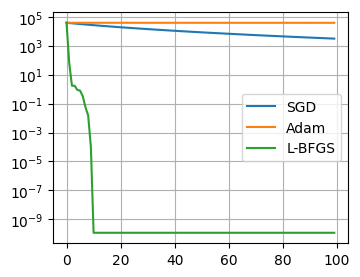

In [16]:
# convergence rate of two methods
plt.figure(figsize=(3.8, 3.0))
plt.semilogy(history_gd, label='SGD')
plt.semilogy(history_adam, label='Adam')
plt.semilogy(history_lbfgs, label='L-BFGS')
plt.grid(True); plt.legend(); plt.show()

**Conclusion about the convergence rate**

As you can see, the figure says it all. The LBFGS gives a much better convergence rate. It is so good that it completely outperforms the stochastic gradient descent and Adam methods after one iteration step. However, must be emphasized that one iteration of LBFGS requires more computational efforts than the SGD. Nevertheless, such computational effort is totally worthy in this particular example. The Adam method does a shitty job.

### Generate neural-style transferred image

Before going to the code, I still need to explain a few more things so that you don't find the code too difficult to understand. Every line of code was written in the way it was for a reason (of course following my reasonsings)

<font color='magenta'>**Definining the closure in the trainining loop**</font>    

Finally, we come to the real business after learning all the key points in the theory of neural style transfer and implementation aspects for that. Unlike the last example using LBFGS in which the function `closure()` can be defined outside the iteration, in the training process below we have to define the `closure()` inside the training loop. This is because the computational graph must be reconstructed in every epoch iteration.

Since, we want to print out the epoch number in the function `closure()`, we must use the list variable to keep track of the epoch number. If you use only one integer variable, this variable will be initilized in the function `closure()` and it is not updated from the last iteration. This is not what we want. The list in Python is passed to the function like "passed by reference in C++", so the update on the list variable can be observed outside the function `closure()`. This is why you see the variable `run = [0]` defined as a list, instead of the integer variable `run = 0`. If you don't believe me, try to change `run = [0]` to `run = 0` to see the effect.

The following weights can be changed. You should play around with them to see the effect of the style versus the content.

In [17]:
content_weight = float(1e3)
style_weight = 1

content_layer_weights = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.2])
style_layer_weights = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.2])

print(f"sum(content_layer_weights) = {content_layer_weights.sum()}")
print(f"sum(style_layer_weights) = {style_layer_weights.sum()}")

sum(content_layer_weights) = 1.0
sum(style_layer_weights) = 1.0


In [18]:
EPOCHS = 300        # number of training iterations
# Save the generated figure n_saves times
n_saves = 10
# save the generated figure every certain number of epochs
every_save = int(EPOCHS // n_saves) 

model = NeuralStyle().to(device=device).eval()
model.requires_grad_(False)
optimizer = optim.LBFGS([generated_img])

In [19]:
img_count = [1]
# try to change this to run = 0 to see the effect that 
# the update on run is not seen outside the function closure()
run = [0]   
mse = nn.MSELoss()
print("Optimizing ...")
while run[0] <= EPOCHS:

    # Define the closure() function that is finally used in the LBFGS optimizer.
    # We need to define the closure 
    def closure():
        with torch.no_grad():
            generated_img.clamp_(0, 1)
        
        optimizer.zero_grad()

        # Forward three images through the model and collect the activations after
        # the convolution layers. See how the model is defined in the class VGG.
        generated_layer_activations = model(generated_img)
        content_layer_activations = model(content_img)
        style_layer_activations = model(style_img)

        # Reset the content loss and style loss to zero.
        content_loss, style_loss = 0.0, 0.0

        # Loop over chosen layers. Since we use the same layers for computing
        # content loss function and style loss function, we can use only one
        # single loop for computing both loss functions. If we use two different
        # sets of chosen convolution layers for these loss functions, the code must
        # be modified appropriately for computing each loss function.
        for j in range(len(generated_layer_activations)):

            _, channel, height, width = content_layer_activations[j].shape
            content_loss += content_layer_weights[j] \
                * mse(generated_layer_activations[j], content_layer_activations[j])

            # Compute the gram matrix for computing style loss
            A_unrolled = generated_layer_activations[j].view(channel, height * width)
            Gram_generated = torch.matmul(A_unrolled, A_unrolled.t())

            A_unrolled = style_layer_activations[j].view(channel, height * width)
            Gram_style = torch.matmul(A_unrolled, A_unrolled.t())

            style_loss += style_layer_weights[j] * mse(Gram_generated, Gram_style)
            
        loss = content_weight * content_loss + style_weight * style_loss
        loss.backward()

        run[0] += 1

        if run[0] % every_save == 0:
            print(f"Epoch [{run[0]}/{EPOCHS}]")
            print(f"style loss = {style_loss.item():4f} | content loss = {content_loss.item():4f}")
            save_image(generated_img,
                   f"./generated-process/{content_name}+{style_name}--{img_count[0]:02d}.jpg")
            img_count[0] += 1
        return content_weight * content_loss + style_weight * style_loss

    optimizer.step(closure)

    # Last correction
    with torch.no_grad():
        generated_img.clamp_(0, 1)

Optimizing ...
Epoch [30/300]
style loss = 8309835.500000 | content loss = 7.277916
Epoch [60/300]
style loss = 2771387.500000 | content loss = 7.943745
Epoch [90/300]
style loss = 950986.375000 | content loss = 8.227481
Epoch [120/300]
style loss = 585298.750000 | content loss = 8.366459
Epoch [150/300]
style loss = 420150.343750 | content loss = 8.449169
Epoch [180/300]
style loss = 333419.031250 | content loss = 8.516891
Epoch [210/300]
style loss = 272805.718750 | content loss = 8.575748
Epoch [240/300]
style loss = 227096.921875 | content loss = 8.627867
Epoch [270/300]
style loss = 196673.843750 | content loss = 8.664782
Epoch [300/300]
style loss = 174457.000000 | content loss = 8.686025


In [20]:
# Finally, the final image is saved.
save_image(generated_img, f"./generated-images/{content_name}+{style_name}.jpg")